In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# Import the Data

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [20]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [22]:
df.head(5)

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Searching for missing values

In [23]:
df.columns[df.isnull().sum()!=0]

Index(['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'electrical', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence',
       'miscfeature'],
      dtype='object')

There are many variables with apparent null values.  Next I want to search for missing values that may not be apparent

In [24]:
nulls = df.columns[df.isnull().sum()!=0]
cols = df.select_dtypes('object')
for col in cols:
    if col not in nulls:
        print(col,": ",df[col].unique())

mszoning :  ['RL' 'RM' 'C (all)' 'FV' 'RH']
street :  ['Pave' 'Grvl']
lotshape :  ['Reg' 'IR1' 'IR2' 'IR3']
landcontour :  ['Lvl' 'Bnk' 'Low' 'HLS']
utilities :  ['AllPub' 'NoSeWa']
lotconfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
landslope :  ['Gtl' 'Mod' 'Sev']
neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
bldgtype :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
housestyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
roofstyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
roofmatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
exterior1st :  [

now checking to see if any numeric values have a minimum as 0 as this could be a missing value

In [25]:
cols = df.select_dtypes(exclude='object')
for col in cols:
    if col not in nulls:
        print(col,": ",df[col].min())

id :  1
mssubclass :  20
lotarea :  1300
overallqual :  1
overallcond :  1
yearbuilt :  1872
yearremodadd :  1950
bsmtfinsf1 :  0
bsmtfinsf2 :  0
bsmtunfsf :  0
totalbsmtsf :  0
firstflrsf :  334
secondflrsf :  0
lowqualfinsf :  0
grlivarea :  334
bsmtfullbath :  0
bsmthalfbath :  0
fullbath :  0
halfbath :  0
bedroomabvgr :  0
kitchenabvgr :  0
totrmsabvgrd :  2
fireplaces :  0
garagecars :  0
garagearea :  0
wooddecksf :  0
openporchsf :  0
enclosedporch :  0
threessnporch :  0
screenporch :  0
poolarea :  0
miscval :  0
mosold :  1
yrsold :  2006
saleprice :  34900


As these have to do with counts and area, I'm assuming 0 is acceptable.  If I had more time I would look more into each

In [26]:
for null in nulls:
    print(null, ": ", df[null].isnull().sum())

lotfrontage :  259
alley :  1369
masvnrtype :  8
masvnrarea :  8
bsmtqual :  37
bsmtcond :  37
bsmtexposure :  38
bsmtfintype1 :  37
bsmtfintype2 :  38
electrical :  1
fireplacequ :  690
garagetype :  81
garageyrblt :  81
garagefinish :  81
garagequal :  81
garagecond :  81
poolqc :  1453
fence :  1179
miscfeature :  1406


In [27]:
(df.isnull().sum(axis=1).max())/df.shape[1]

0.18518518518518517

The greatest percentage of missing values in 1 row is about 19%.  If 20% of the data was missing, I would drop that row.

In [28]:
categorical = df.select_dtypes('object').columns

In [29]:
categorical_nulls = [x for x in nulls if x in categorical]
categorical_nulls

['alley',
 'masvnrtype',
 'bsmtqual',
 'bsmtcond',
 'bsmtexposure',
 'bsmtfintype1',
 'bsmtfintype2',
 'electrical',
 'fireplacequ',
 'garagetype',
 'garagefinish',
 'garagequal',
 'garagecond',
 'poolqc',
 'fence',
 'miscfeature']

Above are the categorical columns with nulls.  As none is a possible value for many of these, such as fence, I will leave them as none.  

In [30]:
df.fillna('None', inplace=True)

In [31]:
# it is hard to determine if None is missing or None just means none

# Looking at histograms of numerical values to determine distribution and check for outliers

## Histogram and outliers for dependent variable, sale price.

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

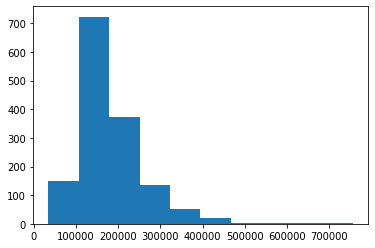

In [31]:
plt.hist(df['saleprice'])

saleprice is not normal,  will try a log transformation.

(array([  4.,   1.,   0.,   5.,   7.,   6.,  26.,  45.,  47., 114., 165.,
        215., 172., 199., 119., 109.,  88.,  52.,  35.,  26.,  12.,   5.,
          4.,   2.,   2.]),
 array([10.46024211, 10.58321134, 10.70618058, 10.82914982, 10.95211906,
        11.07508829, 11.19805753, 11.32102677, 11.443996  , 11.56696524,
        11.68993448, 11.81290371, 11.93587295, 12.05884219, 12.18181142,
        12.30478066, 12.4277499 , 12.55071913, 12.67368837, 12.79665761,
        12.91962684, 13.04259608, 13.16556532, 13.28853455, 13.41150379,
        13.53447303]),
 <BarContainer object of 25 artists>)

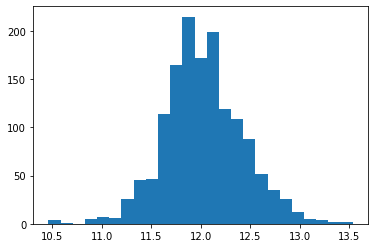

In [32]:
plt.hist(np.log(df['saleprice']), bins=25)

I'm creating a log transformed saleprice just to do outlier detection for saleprice

In [33]:
df['log_sale'] = np.log(df['saleprice'])

In [34]:
mu = df['log_sale'].mean()
std = df['log_sale'].std()
sale_outliers = df[(df['log_sale']<mu-3*std)|(df['log_sale']>mu+3*std)].index

In [35]:
sale_outliers

Int64Index([30, 441, 496, 533, 691, 803, 898, 916, 968, 1046, 1169, 1182], dtype='int64')

As there are only 12 outliers on saleprice, I will drop those 12.

In [36]:
df.drop(sale_outliers, inplace=True)
df.drop('log_sale',axis=1,inplace=True)

I was going to go through each variable and for numeric variables look for outliers, for categorical variables, look for outliers for saleprice by each category, then drop any outliers that were persistent across different variables and hard cap other outliers.  But since this is an assignment and not a capstone project, that would take too long.  So I decided to just drop the outliers with sale price.

## Looking for correlation with numeric values

In [37]:
numeric = df.select_dtypes(exclude='object').columns

In [38]:
np.abs((df[numeric].corr())['saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.797783
grlivarea        0.687023
garagecars       0.650162
garagearea       0.633247
totalbsmtsf      0.596056
firstflrsf       0.587994
fullbath         0.551160
yearbuilt        0.538666
yearremodadd     0.524494
totrmsabvgrd     0.513975
fireplaces       0.463739
bsmtfinsf1       0.365029
openporchsf      0.343362
wooddecksf       0.331939
secondflrsf      0.294488
halfbath         0.278365
lotarea          0.263064
bsmtfullbath     0.238992
bsmtunfsf        0.214948
bedroomabvgr     0.154252
kitchenabvgr     0.144405
enclosedporch    0.126999
screenporch      0.105400
mssubclass       0.090707
overallcond      0.083598
mosold           0.075875
threessnporch    0.051708
id               0.038591
bsmthalfbath     0.035930
poolarea         0.031134
yrsold           0.027997
lowqualfinsf     0.025323
miscval          0.021231
bsmtfinsf2       0.017715
Name: saleprice, dtype: float64

In [39]:
corr_numeric = np.abs((df[numeric].corr())['saleprice'])

In [40]:
top_corr_numeric = corr_numeric[(corr_numeric>0.5)&(corr_numeric<0.9)]
top_corr_numeric.sort_values(ascending=False)

overallqual     0.797783
grlivarea       0.687023
garagecars      0.650162
garagearea      0.633247
totalbsmtsf     0.596056
firstflrsf      0.587994
fullbath        0.551160
yearbuilt       0.538666
yearremodadd    0.524494
totrmsabvgrd    0.513975
Name: saleprice, dtype: float64

The above ten variables appear highly correlated with saleprice.  I want to first visualize these with scatterplots and then check for any correlation between these variables.

In [41]:
top_corr_numeric_names = top_corr_numeric.index
top_corr_numeric_names

Index(['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'firstflrsf',
       'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea'],
      dtype='object')

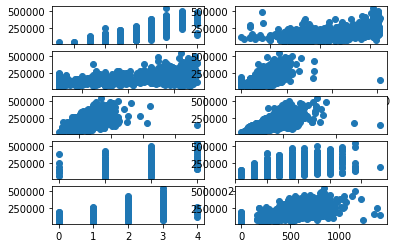

In [43]:
fig, axs = plt.subplots(5,2)
i = 0
for col in top_corr_numeric_names:
    axs[i//2,i%2].scatter(col,'saleprice',data=df)
    i=i+1

In [44]:
df[top_corr_numeric.index].corr()

overallqual  yearbuilt  yearremodadd  totalbsmtsf  firstflrsf  \
overallqual      1.000000   0.568794      0.545061     0.517502    0.452407   
yearbuilt        0.568794   1.000000      0.588030     0.384080    0.270001   
yearremodadd     0.545061   0.588030      1.000000     0.280705    0.227220   
totalbsmtsf      0.517502   0.384080      0.280705     1.000000    0.811886   
firstflrsf       0.452407   0.270001      0.227220     0.811886    1.000000   
grlivarea        0.574178   0.186297      0.279669     0.429916    0.547075   
fullbath         0.536162   0.463264      0.433108     0.304518    0.362093   
totrmsabvgrd     0.404157   0.080174      0.178098     0.257649    0.387671   
garagecars       0.588830   0.530976      0.411348     0.419796    0.423683   
garagearea       0.550581   0.471435      0.362095     0.476560    0.478084   

              grlivarea  fullbath  totrmsabvgrd  garagecars  garagearea  
overallqual    0.574178  0.536162      0.404157    0.588830    0.550581  
yearbuilt      0.186297  0.463264      0.080174    0.530976    0.471435  
yearremodadd   0.279669  0.433108      0.178098    0.411348    0.362095  
totalbsmtsf    0.429916  0.304518      0.257649    0.419796    0.476560  
firstflrsf     0.547075  0.362093      0.387671    0.423683    0.478084  
grlivarea      1.000000  0.617792      0.825776    0.454116    0.457061  
fullbath       0.617792  1.000000      0.542746    0.458881    0.393330  
totrmsabvgrd   0.825776  0.542746      1.000000    0.345013    0.320371  
garagecars     0.454116  0.458881      0.345013    1.000000    0.880058  
garagearea     0.457061  0.393330      0.320371    0.880058    1.000000

In [45]:
df[top_corr_numeric.index].corr()['overallqual']

overallqual     1.000000
yearbuilt       0.568794
yearremodadd    0.545061
totalbsmtsf     0.517502
firstflrsf      0.452407
grlivarea       0.574178
fullbath        0.536162
totrmsabvgrd    0.404157
garagecars      0.588830
garagearea      0.550581
Name: overallqual, dtype: float64

Overall quality seems highly correlated with everything except firstflrsf and totalrmsabv ground.  This being the case, overall quality, firstflsf, and totalrmsabvgrd will be the only 3 numeric variables included in the model.

In [46]:
numeric_variables = ['overallqual','firstflrsf','totrmsabvgrd']

In [48]:
len(categorical)

43

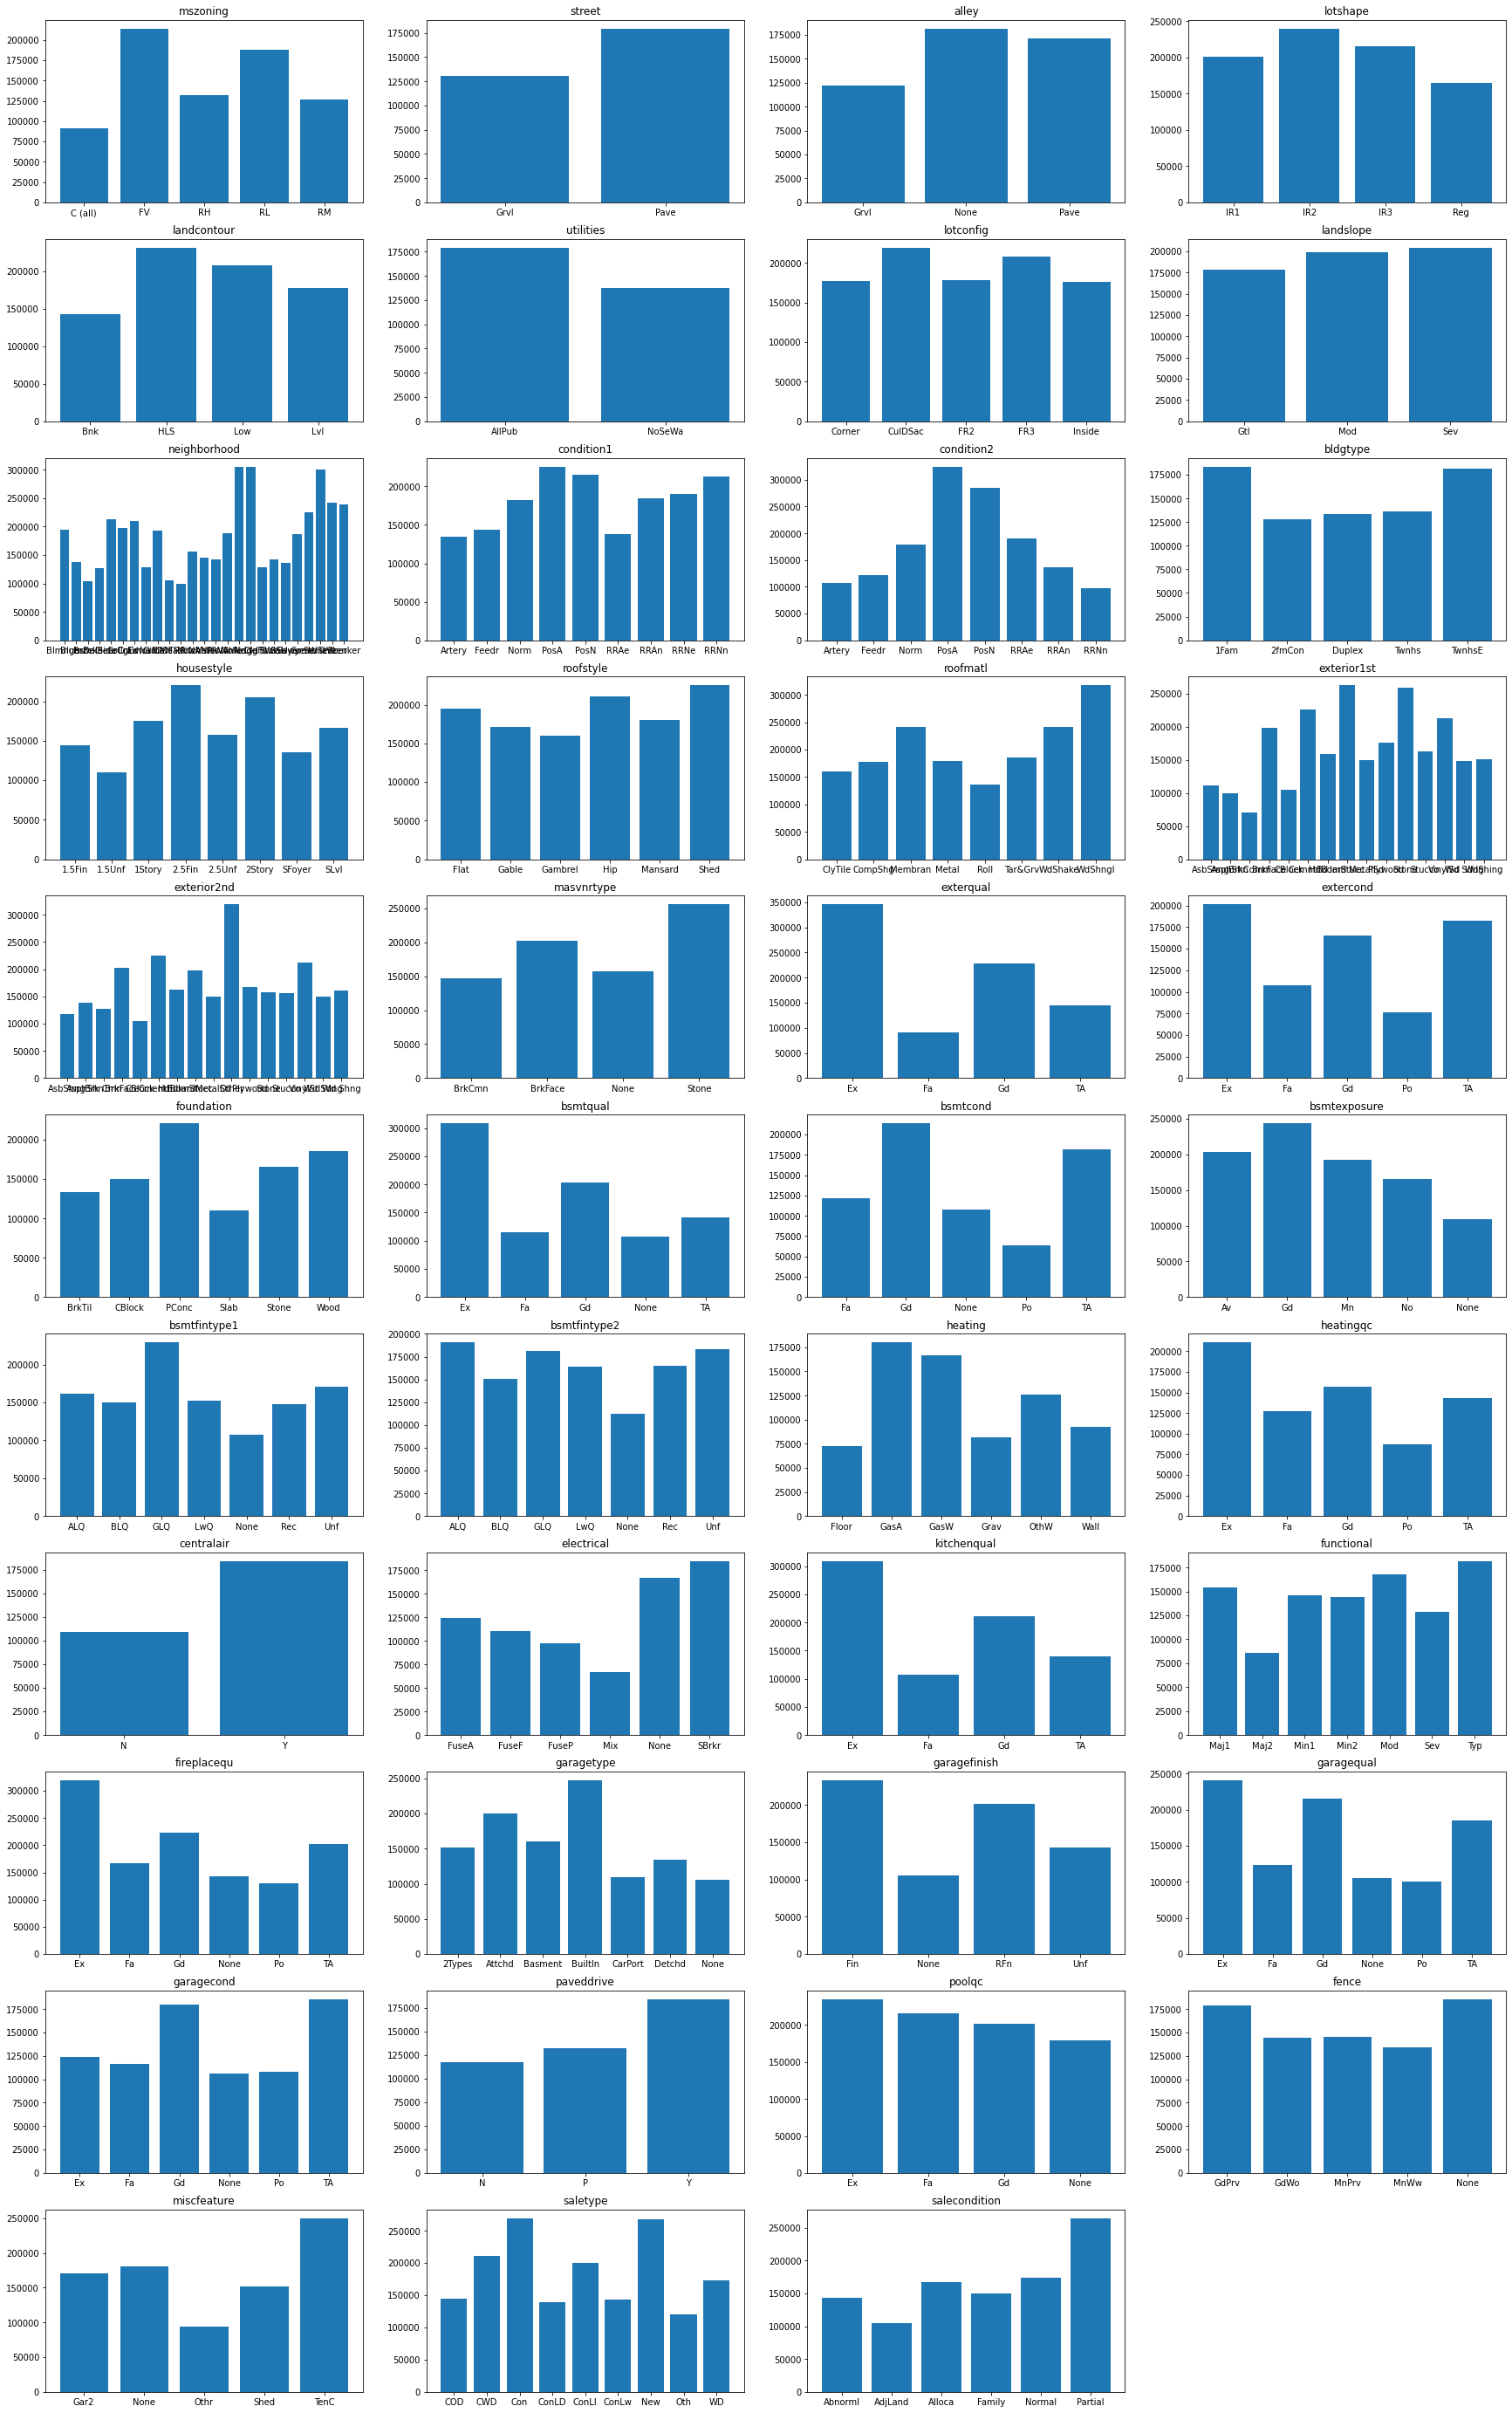

In [57]:
plt.figure(figsize=(30,50))
for i in range(43):
    plt.subplot(11,4,i+1)
    col = categorical[i]
    plt.bar(df.groupby(col).mean().index,df.groupby(col)['saleprice'].mean())
    plt.title(col)

Many of these variables seems to change within subcategories.  For two variables, I'm going to pick neighborhood and exterior 1st.

In [60]:
variables = numeric_variables + ['neighborhood','exterior1st','saleprice'] 
variables

['overallqual',
 'firstflrsf',
 'totrmsabvgrd',
 'neighborhood',
 'exterior1st',
 'saleprice']

In [61]:
df2 = pd.get_dummies(df[variables])

# Creating linear regression

In [63]:
X = df2.drop('saleprice', axis=1)
Y = df2.saleprice

In [64]:
X.head()

overallqual  firstflrsf  totrmsabvgrd  neighborhood_Blmngtn  \
0            7         856             8                     0   
1            6        1262             6                     0   
2            7         920             6                     0   
3            7         961             7                     0   
4            8        1145             9                     0   

   neighborhood_Blueste  neighborhood_BrDale  neighborhood_BrkSide  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     0   

   neighborhood_ClearCr  neighborhood_CollgCr  neighborhood_Crawfor  ...  \
0                     0                     1                     0  ...   
1                     0                     0                     0  ...   
2                     0                     1                     0  ...   
3                     0                     0                     1  ...   
4                     0                     0                     0  ...   

   exterior1st_CemntBd  exterior1st_HdBoard  exterior1st_ImStucc  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   exterior1st_MetalSd  exterior1st_Plywood  exterior1st_Stone  \
0                    0                    0                  0   
1                    1                    0                  0   
2                    0                    0                  0   
3                    0                    0                  0   
4                    0                    0                  0   

   exterior1st_Stucco  exterior1st_VinylSd  exterior1st_Wd Sdng  \
0                   0                    1                    0   
1                   0                    0                    0   
2                   0                    1                    0   
3                   0                    0                    1   
4                   0                    1                    0   

   exterior1st_WdShing  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 43 columns]

In [65]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     136.2
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        09:59:16   Log-Likelihood:                -17100.
No. Observations:                1448   AIC:                         3.428e+04
Df Residuals:                    1406   BIC:                         3.451e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.212e+04   7073.382     -7.368      0.000    -6.6e+04   -3.82e+04
overallqual           2.187e+04   1029.251     21.244      0.000    1.98e+04    2.39e+04
firstflrsf              37.7512      3.031     12.455      0.000      31.806      43.697
totrmsabvgrd          8145.7163    649.998     12.532      0.000    6870.646    9420.787
neighborhood_Blmngtn -2.598e+04   8110.198     -3.203      0.001   -4.19e+04   -1.01e+04
neighborhood_Blueste -1.279e+04   2.26e+04     -0.565      0.572   -5.72e+04    3.16e+04
neighborhood_BrDale  -3.894e+04   8407.601     -4.631      0.000   -5.54e+04   -2.24e+04
neighborhood_BrkSide -1.526e+04   4698.445     -3.248      0.001   -2.45e+04   -6045.033
neighborhood_ClearCr  2.834e+04   6325.162      4.480      0.000    1.59e+04    4.07e+04
neighborhood_CollgCr  -251.7703   3317.721     -0.076      0.940   -6759.987    6256.447
neighborhood_Crawfor  1.512e+04   4862.432      3.109      0.002    5577.642    2.47e+04
neighborhood_Edwards -2.333e+04   3700.690     -6.303      0.000   -3.06e+04   -1.61e+04
neighborhood_Gilbert    11.2389   4134.420      0.003      0.998   -8099.057    8121.535
neighborhood_IDOTRR  -3.132e+04   5842.740     -5.361      0.000   -4.28e+04   -1.99e+04
neighborhood_MeadowV -4.089e+04   9609.514     -4.256      0.000   -5.97e+04    -2.2e+04
neighborhood_Mitchel -1.179e+04   4875.371     -2.418      0.016   -2.14e+04   -2222.922
neighborhood_NAmes    -1.65e+04   2737.405     -6.027      0.000   -2.19e+04   -1.11e+04
neighborhood_NPkVill -2.135e+04   1.12e+04     -1.902      0.057   -4.34e+04     669.174
neighborhood_NWAmes  -9527.8255   4205.444     -2.266      0.024   -1.78e+04   -1278.205
neighborhood_NoRidge   6.03e+04   5808.902     10.381      0.000    4.89e+04    7.17e+04
neighborhood_NridgHt  4.677e+04   4678.107      9.998      0.000    3.76e+04    5.59e+04
neighborhood_OldTown -2.918e+04   3582.005     -8.147      0.000   -3.62e+04   -2.22e+04
neighborhood_SWISU   -2.645e+04   6737.810     -3.926      0.000   -3.97e+04   -1.32e+04
neighborhood_Sawyer  -1.334e+04   4160.474     -3.206      0.001   -2.15e+04   -5176.714
neighborhood_SawyerW -2426.0993   4498.719     -0.539      0.590   -1.13e+04    6398.825
neighborhood_Somerst  1.162e+04   4066.865      2.857      0.004    3642.096    1.96e+04
neighborhood_StoneBr  5.167e+04   7068.515      7.310      0.000    3.78e+04    6.55e+04
neighborhood_Timber   1.813e+04   5598.965      3.238      0.001    7144.938    2.91e+04
neighborhood_Veenker  3.526e+04   9926.897      3.552      0.000    1.58e+04    5.47e+04
exterior1st_AsbShng  -4832.5230   8413.697     -0.574      0.566   -2.13e+04    1.17e+04
exterior1st_AsphShn  -6.187e+04   3.14e+04     -1.972      0.049   -1.23e+05    -327.849
exterior1st_BrkComm  -1.958e+04   2.25e+04     -0.872    